# Weight decay

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_09 import *

## Imagenette data

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
c = y_train.max().item()+1

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, 128), c)
data.c_out = 10

In [ ]:
train_dl,valid_dl = get_dls(ll.train,ll.valid,bs, num_workers=8)

In [ ]:
sched = combine_scheds([0.25, 0.75], [sched_cos(0.1/25, 0.1), sched_cos(0.1, 0.)]) 

In [ ]:
cbs = [partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(ParamScheduler, 'lr', sched)]

In [ ]:
def mnist_resize(x): return x.view(x.size(0), 1, 28, 28)
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

def get_model():
    model = nn.Sequential(
        Lambda(mnist_resize),
        conv(1, 8), # 14
        nn.BatchNorm2d(8),
        nn.ReLU(),
        conv(8, 16), # 7
        nn.BatchNorm2d(16),
        nn.ReLU(),
        conv(16, 32), # 4
        nn.BatchNorm2d(32),
        nn.ReLU(),
        conv(32, 16), # 2
        nn.BatchNorm2d(16),
        nn.ReLU(),
        conv(16, 10), # 1
        nn.BatchNorm2d(10),
        Lambda(flatten)     # remove (1,1) grid
    )
    init_cnn(model)
    return model

In [ ]:
learn,run = get_runner(get_model(), data, lr=0.1, cbs=cbs, opt_func=optim.Adam)

In [ ]:
run.fit(3, learn)

train: [0.4115347265625, tensor(0.9016, device='cuda:0')]
valid: [0.14199490966796874, tensor(0.9617, device='cuda:0')]
train: [0.0809953125, tensor(0.9751, device='cuda:0')]
valid: [0.050419244384765624, tensor(0.9840, device='cuda:0')]
train: [0.040488916015625, tensor(0.9875, device='cuda:0')]
valid: [0.040276104736328124, tensor(0.9895, device='cuda:0')]


## Weight decay

Weight decay comes from the idea of L2 regularization, which consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

Why would it prevent overfitting? The idea is that the larger the coefficient are, the more sharp canyons we will have in the loss function. If we take the basic example of parabola, `y = a * (x**2)`, the larger `a` is, the more *narrow* the parabola is.

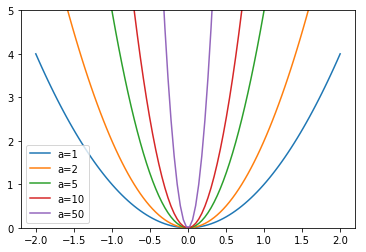

In [ ]:
x = torch.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots()
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();

So by letting our model learn high parameters, it might fit all the data points in the training set with an over-complex function that has very sharp changes, which will lead to overfitting.

<img src="images/overfit.png" alt="Fitting vs over-fitting" width="600">

Limiting our weights from growing to much is going to hinder the training of the model, but it will yield to a state where it generalizes better. Going back to the theory a little bit, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss:
``` python
loss_with_wd = loss + (wd / 2) * sum([(p ** 2).sum() for p in model_parameters])
```

In practice though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high schoool math, you should now that the derivative of `p ** 2` with respect to `p` is simple `2 * p`, so adding that big sum to our loss is exactly the same as doing
``` python
weight.grad += wd * weight
```

for every weight in our model, which is equivalent to (in the case of vanilla SGD) updating the parameters
with
``` python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

This last formula explains why the name of this technique is weight decay, as each weight is decayed by a factor `lr * wd`. 

This only works for standard SGD, as we have seen that with momentum, RMSProp or in Adam, the update has some additional formulas around the gradient. In those cases, the formula that comes from L2 regularization:
``` python
weight.grad += wd * weight
```
is different than weight decay
``` python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

Most libraries use the first one, but as it was pointed out in [Decoupled Weight Regularization](https://arxiv.org/pdf/1711.05101.pdf) by Ilya Loshchilov and Frank Hutter, it is better to use the second one with the Adam optimizer, which is why fastai made it its default.

In [ ]:
class Optimizer(optim.Optimizer):
    def __init__(self, params, steppers, **defaults): 
        super().__init__(params, defaults)
        self.steppers = listify(steppers)
        
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None:
                    for step in self.steppers: p = step(p,pg)
                    
    def get_step(self, pg, p): return p.grad.data

In [ ]:
def l2reg(p,pg): 
    p.data.mul_(1 - pg['lr'] * pg['wd'])
    return p

In [ ]:
def weight_decay(p,pg): 
    p.grad.data.add_(pg['wd'], p.data)
    return p

In [ ]:
def sgd_step(p, pg):
    p.data.add_(-pg['lr'], p.grad.data)
    return p

A stepper may introduce new hyperparameters so we associate a `defaults` variable to it to make sure it's present in the param groups.

In [ ]:
class Stepper():
    def __init__(self, step_func, defaults):
        self.step_func,self.defaults = step_func,defaults
    def __call__(self, p, pg): return self.step_func(p, pg)

In [ ]:
L2Reg = Stepper(l2reg, {'wd':0.})
WeightDecay = Stepper(weight_decay, {'wd':0.})

In [ ]:
class Optimizer(optim.Optimizer):
    def __init__(self, params, steppers, **defaults): 
        self.steppers = listify(steppers)
        stepper_defaults = {}
        for stepper in self.steppers: 
            if isinstance(stepper, Stepper): stepper_defaults.update(stepper.defaults)
        super().__init__(params, {**stepper_defaults, **defaults})
        
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None:
                    for step in self.steppers: p = step(p,pg)
                    
    def get_step(self, pg, p): return p.grad.data

In [ ]:
opt_func = partial(Optimizer, steppers=[L2Reg, sgd_step])

In [ ]:
opt = opt_func(model.parameters(), lr=0.1)

In [ ]:
opt.param_groups[0]['wd']

0.0

In [ ]:
opt = opt_func(model.parameters(), lr=0.1, wd=1e-4)

In [ ]:
opt.param_groups[0]['wd']

0.0001

### With momentum

Momentum requires to add some state. We need to save the moving average of the gradients to be able to do the step and store this inside the optimizer state if we want it saved by PyTorch (when doing checkpointing).

In [ ]:
class StatefulOptimizer(optim.Optimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.steppers,self.stats = listify(steppers),listify(stats)
        base_defaults = {}
        for stepper in self.steppers: 
            if hasattr(stepper, 'defaults'): base_defaults.update(stepper.defaults)
        for stat in self.stats: base_defaults.update(stat._defaults)
        super().__init__(params, {**base_defaults, **defaults})
        
    def step(self):
        for pg in self.param_groups:
            for p in pg['params']:
                if p.grad is not None:
                    if p not in self.state:
                        init_state = {}
                        for stat in self.stats: init_state.update(stat.init_state(p))
                        self.state[p] = init_state
                    state = self.state[p]
                    for stat in self.stats:    state = stat.update(p, pg, state)
                    for step in self.steppers: p = step(p, pg, state)
                    self.state[p] = state

In [ ]:
class Stat():
    _defaults = {}
    def init_state(self, p):        raise NotImplementedError
    def update(self, p, pg, state): raise NotImplementedError    

In [ ]:
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, pg, state):
        state['grad_avg'].mul_(pg['mom']).add_(p.grad.data)
        return state

In [ ]:
def momentum_step(p, pg, state):
    p.data.add_(-pg['lr'], state['grad_avg'])
    return p

In [ ]:
opt_func = partial(StatefulOptimizer, steppers=momentum_step, stats=AverageGrad())

In [ ]:
learn,run = get_runner(get_model(), data, lr=0.1, cbs=cbs, opt_func=opt_func)

In [ ]:
run.fit(3, learn)

train: [0.55733265625, tensor(0.8378, device='cuda:0')]
valid: [0.10653912353515625, tensor(0.9704, device='cuda:0')]
train: [0.087080419921875, tensor(0.9734, device='cuda:0')]
valid: [0.058975927734375, tensor(0.9831, device='cuda:0')]
train: [0.0512982373046875, tensor(0.9844, device='cuda:0')]
valid: [0.05124519653320313, tensor(0.9851, device='cuda:0')]


In [ ]:
class StatefulOptimizer(Optimizer):
    def __init__(self, params, stats_func, callbacks=None, **defaults):
        super().__init__(params, callbacks=callbacks, **{**stats_func._defaults, **defaults})
        self.stats_func = stats_func

    def get_state(self, p):
        # First time this param seen - create a stats obj for it and put it in `state`
        if p not in self.state: self.state[p] = self.stats_func()
        return self.state[p]
    
    def get_step(self, pg, p):
        # PyTorch will save anything stored in `state`; it's indexed by param
        stats = self.get_state(p)
        return stats.update(p.grad.data, pg)

In [ ]:
class StepFunc(): _defaults = {}

class MomentumStep(StepFunc):
    _defaults = dict(mom=0.9)

    def update(self, grad, pg):
        if not hasattr(self,'grad_avg'): self.grad_avg = grad.clone()
        else: self.grad_avg.mul_(pg['mom']).add_(grad)
        return self.grad_avg

In [ ]:
class GradStats(StepFunc):
    _defaults = dict(eps=1e-5, grad_mom=0., sqr_mom=0., grad_damp=1., sqr_damp=1.)

    def __init__(self, grad_damp=True, sqr_damp=True):
        self.grad_damp,self.sqr_damp = grad_damp,sqr_damp
    
    def update(self, grad, pg):
        if not hasattr(self,'grad_avg'):
            if self.grad_damp: pg['grad_damp'] = 1-pg['grad_mom']
            if self.sqr_damp : pg['sqr_damp' ] = 1-pg['sqr_mom' ]
            self.grad_avg,self.sqr_avg = torch.zeros_like(grad),torch.zeros_like(grad)
            self.iter = 0

        self.iter += 1
        self.grad_avg.mul_(pg['grad_mom']).add_(pg['grad_damp'],grad)
        # Inplace version of:
        # self.sqr_avg  = self.sqr_avg *self.sqr_mom  + (grad*grad)*self.sqr_damp
        self.sqr_avg.mul_(pg['sqr_mom']).addcmul_(pg['sqr_damp'],grad,grad)
        # If grad_damp==1-grad_mom:
        # debias1 = 1 - self.grad_mom**self.iter
        debias1 = pg['grad_damp'] * (1 - pg['grad_mom']**self.iter) / (1-pg['grad_mom'])
        debias2 = pg['sqr_damp']  * (1 - pg['sqr_mom'] **self.iter) / (1-pg['sqr_mom'] )
        return self.grad_avg/debias1 / (self.sqr_avg/debias2 + pg['eps']).sqrt()

In [ ]:
opt_func = partial(StatefulOptimizer, stats_func=GradStats, callbacks=l2reg, wd=0.01, grad_mom=0.9, sqr_mom=0.99)

In [ ]:
learn,run = get_runner(get_model(), data, lr=0.1, cbs=cbs, opt_func=opt_func)

In [ ]:
run.fit(3, learn)

train: [0.0588003759765625, tensor(0.9824, device='cuda:0')]
valid: [0.07093203735351562, tensor(0.9793, device='cuda:0')]
train: [0.063275205078125, tensor(0.9790, device='cuda:0')]
valid: [0.04873742980957031, tensor(0.9862, device='cuda:0')]
train: [0.03001255615234375, tensor(0.9910, device='cuda:0')]
valid: [0.034345028686523435, tensor(0.9904, device='cuda:0')]


In [ ]:
class LAMBStep(StepFunc):
    _defaults = dict(eps=1e-5, grad_mom=0., sqr_mom=0., grad_damp=1., sqr_damp=1.)

    def __init__(self, grad_damp=True, sqr_damp=True):
        self.grad_damp,self.sqr_damp = grad_damp,sqr_damp
    
    def update(self, grad, pg):
        if not hasattr(self,'grad_avg'):
            if self.grad_damp: pg['grad_damp'] = 1-pg['grad_mom']
            if self.sqr_damp : pg['sqr_damp' ] = 1-pg['sqr_mom' ]
            self.grad_avg,self.sqr_avg = torch.zeros_like(grad),torch.zeros_like(grad)
            self.iter = 0

        self.iter += 1
        self.grad_avg.mul_(pg['grad_mom']).add_(pg['grad_damp'],grad)
        # Inplace version of:
        # self.sqr_avg  = self.sqr_avg *self.sqr_mom  + (grad*grad)*self.sqr_damp
        self.sqr_avg.mul_(pg['sqr_mom']).addcmul_(pg['sqr_damp'],grad,grad)
        # If grad_damp==1-grad_mom:
        # debias1 = 1 - self.grad_mom**self.iter
        debias1 = pg['grad_damp'] * (1 - pg['grad_mom']**self.iter) / (1-pg['grad_mom'])
        debias2 = pg['sqr_damp']  * (1 - pg['sqr_mom'] **self.iter) / (1-pg['sqr_mom'] )
        return self.grad_avg/debias1 / (self.sqr_avg/debias2 + pg['eps']).sqrt()

In [ ]:
%time run.fit(1, learn)

train: [1.7320294019989917, tensor(0.4031, device='cuda:0')]
valid: [1.419897705078125, tensor(0.4900, device='cuda:0')]
CPU times: user 14.3 s, sys: 6.84 s, total: 21.2 s
Wall time: 22.4 s


In [ ]:
opt_func = partial(StatefulOptimizer, stats_func=MomentumStep, callbacks=weight_decay, wd=1e-4)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.05, conv_layer, opt_func=opt_func, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [1.752493135130681, tensor(0.3931, device='cuda:0')]
valid: [1.61988427734375, tensor(0.4780, device='cuda:0')]
CPU times: user 14.5 s, sys: 7.12 s, total: 21.6 s
Wall time: 22.7 s
